In [1]:
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import sys
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\concorde')
from plots import scatter_interpolate
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Polygon, Point, LineString
import dask
from tqdm.dask import TqdmCallback
import itertools
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})
from matplotlib.offsetbox import AnchoredText

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

###### Select in and out Storms

In [5]:
df = pd.read_pickle(r'..\data\STORM\processed\STORM_NA_R2.pkl')

In [11]:
xi = -85
yi = 50
xf = -60
yf = 20

box = gpd.GeoDataFrame(geometry = [Polygon([[xi, yi], [xi, yf], [xf, yf], [xf, yi], [xi, yi]])], crs = 4326)

In [ ]:
df.mean

In [35]:
@dask.delayed
def splitStorms(df, i):
    dfsub = df[df.tc_number == i]
    ixClose = dfsub.loc[:, 'dist_to_NC'].idxmin()
    pntX, pntY = dfsub.loc[ixClose, 'lon'], dfsub.loc[ixClose, 'lat']
    d = float(dfsub.mean_trajectory.unique())  
    
    ## possible in
    if box.geometry[0].contains(Point([pntX, pntY])):
        if 45 < d < 135: ## out
            a = [0]*len(dfsub)
        else: ## in
            a = [1]*len(dfsub)
    ## out
    else:
        a = [0]*len(dfsub)
    
    return a

tasks = [splitStorms(df, i) for i in df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

auxMerged = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxMerged))

df['In'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [39]:
df.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2_InOut.pkl')

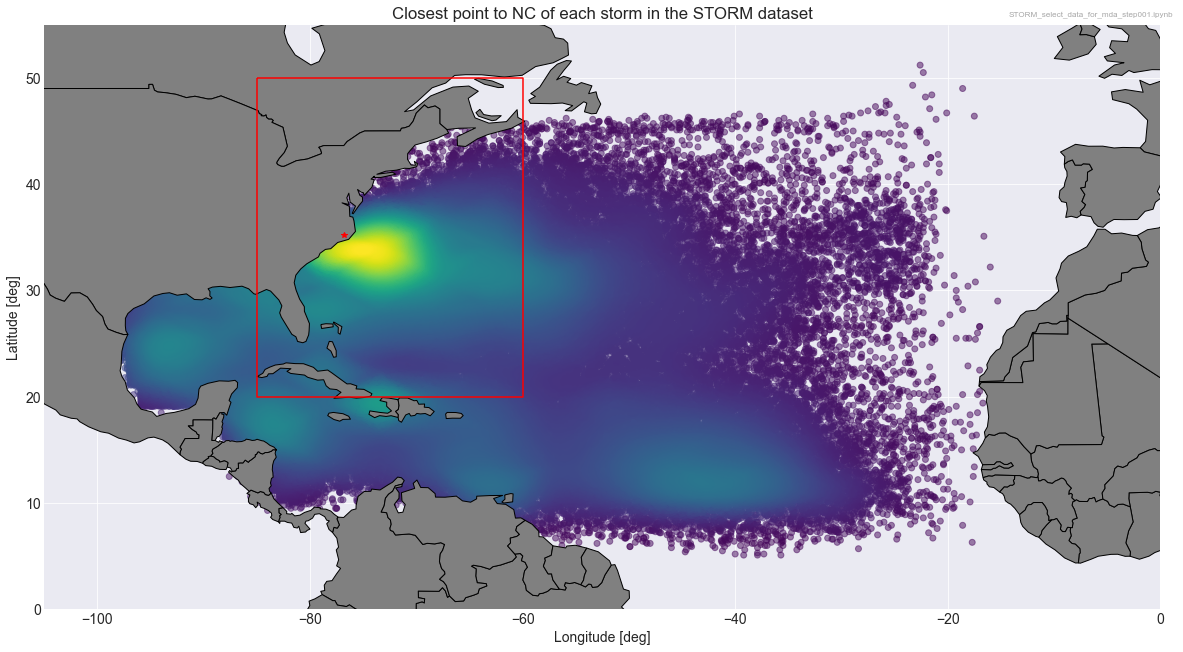

In [14]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2_InOut.pkl')
a = df.groupby('tc_number')['dist_to_NC'].idxmin()
dfNC = df.loc[a, :]
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
x = dfNC.loc[:, 'lon'].values
y = dfNC.loc[:, 'lat'].values
z = scatter_interpolate(x,y)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')
fig, ax = plt.subplots(figsize = (20, 20))

ax.scatter(x, y, c = z, cmap = cm, alpha = 0.5)
dfworld.plot(ax = ax, color = 'grey', edgecolor = 'k')
box.boundary.plot(ax = ax, color = 'r')
ax.plot([-76.8], [35.2], color = 'r', marker = '*')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Closest point to NC of each storm in the STORM dataset')

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

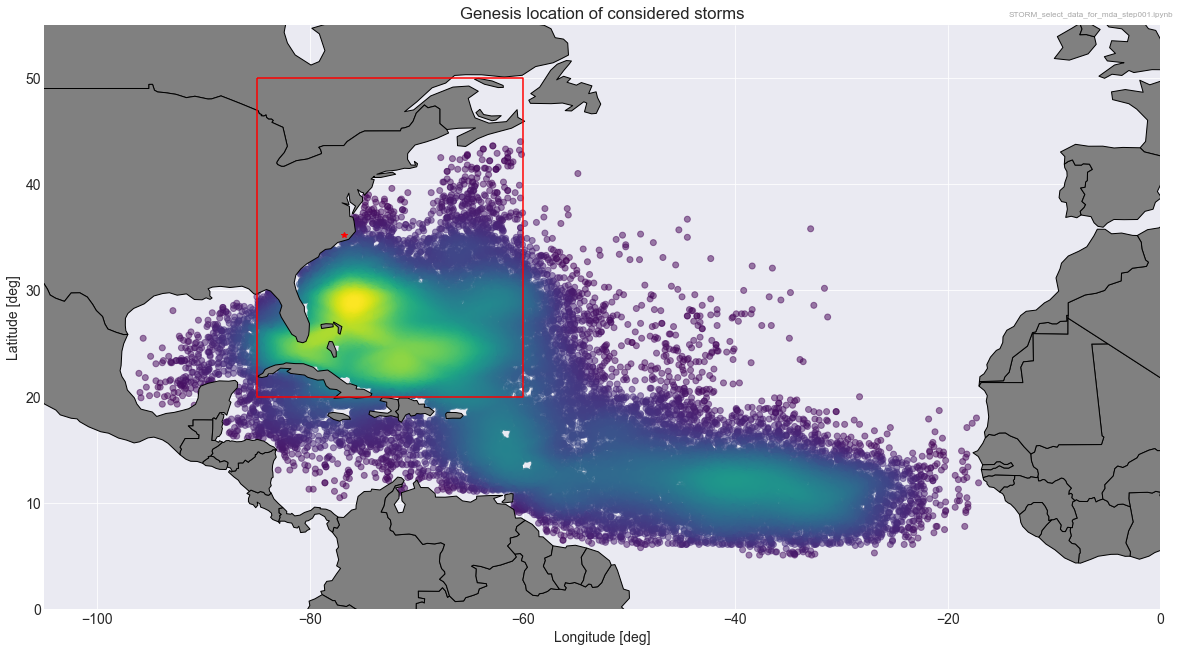

In [17]:
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2_InOut.pkl')
dfgen = df[(df.time_step == 0) & (df.In == 1)]
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
x = dfgen.loc[:, 'lon'].values
y = dfgen.loc[:, 'lat'].values
z = scatter_interpolate(x,y)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')
fig, ax = plt.subplots(figsize = (20, 20))

ax.scatter(x, y, c = z, cmap = cm, alpha = 0.5)
dfworld.plot(ax = ax, color = 'grey', edgecolor = 'k')
box.boundary.plot(ax = ax, color = 'r')
ax.plot([-76.8], [35.2], color = 'r', marker = '*')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Genesis location of considered storms')

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

In [40]:
## In
len(df[(df.time_step == 0) & (df.In == 1)])

32329

In [41]:
## Out
len(df[(df.time_step == 0) & (df.In == 0)])

77150

###### Storms to LineStrings

In [44]:
geom = []
cat = []
min_pres = []
max_ws = []
rmax_ws = []
lf = []
d2NC = []
traj = []
stormid = []
for i in tqdm(df.tc_number.unique()):
    subdf = df[df.tc_number == i]
    if subdf.iloc[0, -1] == 1:
        ls = LineString(list(zip(subdf.lon, subdf.lat)))
        geom.append(ls)
        cat.append(subdf.cat.max())
        min_pres.append(subdf.min_press.min())
        max_ws.append(subdf.max_ws.max())
        rmax_ws.append(subdf.rad_to_max_ws.mean())
        lf.append(subdf.landfall.max())
        d2NC.append(subdf.dist_to_NC.min())
        traj.append(subdf.mean_trajectory.iloc[0])
        stormid.append(i)
gdfIn = gpd.GeoDataFrame(geometry = geom, crs = 4326)
gdfIn['cat_max'] = cat
gdfIn['min_pres'] = min_pres
gdfIn['max_ws'] = max_ws
gdfIn['rmax_ws'] = rmax_ws
gdfIn['lf'] = lf
gdfIn['d2NC'] = d2NC
gdfIn['traj'] = traj
gdfIn['stormid'] = stormid

gdfIn.to_file(r'C:\Users\tacuevas\NCSU\Research\Thesis\gis\gpkg\STORM_NA_R2_IN.gpkg', driver = 'GPKG')

100%|█████████████████████████████████████████████████████████████████████████| 109479/109479 [13:20<00:00, 136.77it/s]


In [45]:
len(gdfIn)

32329

In [46]:
geom = []
cat = []
min_pres = []
max_ws = []
rmax_ws = []
lf = []
d2NC = []
traj = []
stormid = []
for i in tqdm(df.tc_number.unique()):
    subdf = df[df.tc_number == i]
    if subdf.iloc[0, -1] == 0:
        ls = LineString(list(zip(subdf.lon, subdf.lat)))
        geom.append(ls)
        cat.append(subdf.cat.max())
        min_pres.append(subdf.min_press.min())
        max_ws.append(subdf.max_ws.max())
        rmax_ws.append(subdf.rad_to_max_ws.mean())
        lf.append(subdf.landfall.max())
        d2NC.append(subdf.dist_to_NC.min())
        traj.append(subdf.mean_trajectory.iloc[0])
        stormid.append(i)
gdfOut = gpd.GeoDataFrame(geometry = geom, crs = 4326)
gdfOut['cat_max'] = cat
gdfOut['min_pres'] = min_pres
gdfOut['max_ws'] = max_ws
gdfOut['rmax_ws'] = rmax_ws
gdfOut['lf'] = lf
gdfOut['d2NC'] = d2NC
gdfOut['traj'] = traj
gdfOut['stormid'] = stormid

gdfOut.to_file(r'C:\Users\tacuevas\NCSU\Research\Thesis\gis\gpkg\STORM_NA_R2_OUT.gpkg', driver = 'GPKG')

100%|█████████████████████████████████████████████████████████████████████████| 109479/109479 [14:02<00:00, 130.01it/s]


In [47]:
len(gdfOut)

77150

In [18]:
gdfin = gpd.read_file(r'C:\Users\tacuevas\NCSU\Research\Thesis\gis\gpkg\STORM_NA_R2_IN.gpkg')
gdfout = gpd.read_file(r'C:\Users\tacuevas\NCSU\Research\Thesis\gis\gpkg\STORM_NA_R2_OUT.gpkg')

In [24]:
gdfin.head()

,cat_max,min_pres,max_ws,rmax_ws,lf,d2NC,traj,stormid,geometry
0,3.0,953.7,50.8,74.080002,1.0,571.303714,306.734075,4,"LINESTRING (-67.90000 22.10000, -68.40000 22.4..."
1,4.0,939.2,52.7,74.080002,0.0,822.784684,347.184714,5,"LINESTRING (-49.40000 13.40000, -50.20000 13.8..."
2,0.0,993.2,22.0,35.496668,0.0,1035.895766,19.242162,8,"LINESTRING (-83.80000 24.60000, -83.70000 24.9..."
3,0.0,993.2,22.0,40.281001,1.0,992.030799,22.104144,9,"LINESTRING (-83.80000 24.60000, -83.70000 24.9..."
4,0.0,1000.4,18.5,56.717500,0.0,666.410514,276.144983,11,"LINESTRING (-76.60000 29.10000, -76.70000 29.1..."


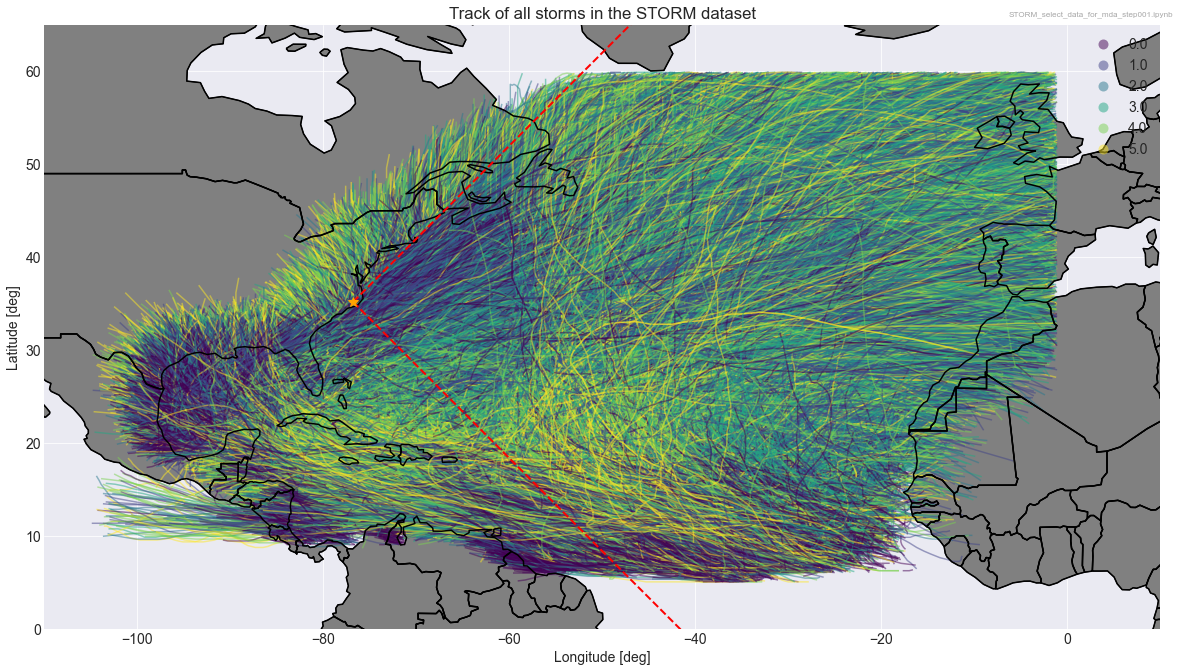

In [44]:
gdfall = pd.concat([gdfin, gdfout], axis = 0)
fig, ax = plt.subplots(figsize = (20, 20))
gdfall.plot(ax = ax, alpha = 0.5, column = 'cat_max', cmap = 'viridis', legend = True, categorical = True)
dfworld.plot(ax = ax, color = 'grey', edgecolor = 'k')
dfworld.boundary.plot(ax = ax, color = 'k')

d0 = 45
d1 = 135
l = 50
xNC, yNC = -76.8, 35.2
xf0 = xNC + l*np.sin(np.deg2rad(d0))
xf1 = xNC + l*np.sin(np.deg2rad(d1))
yf0 = yNC + l*np.cos(np.deg2rad(d0))
yf1 = yNC + l*np.cos(np.deg2rad(d1))
ax.plot([xNC, xf0], [yNC, yf0], c = 'r', ls = '--', lw = 2)
ax.plot([xNC, xf1], [yNC, yf1], c = 'r', ls = '--', lw = 2)

# box.boundary.plot(ax = ax, color = 'r')
ax.plot([xNC], [yNC], color = 'orange', marker = '*', ms = 10)
ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Track of all storms in the STORM dataset')

leg = ax.get_legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')
# leg.set_frameon(True)
# leg.set_bbox_to_anchor((1.15,0.5))

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

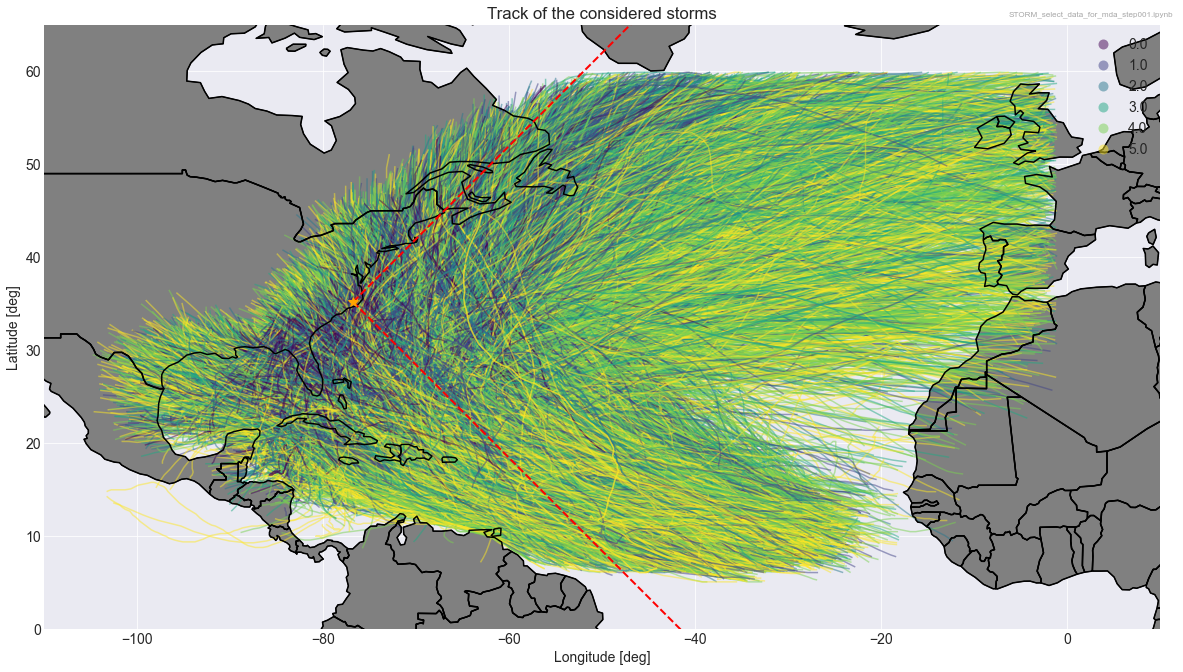

In [45]:
gdfall = pd.concat([gdfin, gdfout], axis = 0)
fig, ax = plt.subplots(figsize = (20, 20))
gdfin.plot(ax = ax, alpha = 0.5, column = 'cat_max', cmap = 'viridis', legend = True, categorical = True)
dfworld.plot(ax = ax, color = 'grey', edgecolor = 'k')
dfworld.boundary.plot(ax = ax, color = 'k')

d0 = 45
d1 = 135
l = 50
xNC, yNC = -76.8, 35.2
xf0 = xNC + l*np.sin(np.deg2rad(d0))
xf1 = xNC + l*np.sin(np.deg2rad(d1))
yf0 = yNC + l*np.cos(np.deg2rad(d0))
yf1 = yNC + l*np.cos(np.deg2rad(d1))
ax.plot([xNC, xf0], [yNC, yf0], c = 'r', ls = '--', lw = 2)
ax.plot([xNC, xf1], [yNC, yf1], c = 'r', ls = '--', lw = 2)

# box.boundary.plot(ax = ax, color = 'r')
ax.plot([xNC], [yNC], color = 'orange', marker = '*', ms = 10)
ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Track of the considered storms')

leg = ax.get_legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')
# leg.set_frameon(True)
# leg.set_bbox_to_anchor((1.15,0.5))

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

###### From track to point

In [49]:
@dask.delayed
def track2point(df, i):
    dfsub = df[(df.tc_number == i)]
    indMinPress = dfsub['min_press'].idxmin()
    indMinDist = dfsub['dist_to_NC'].idxmin()
    l = [float(dfsub.year.unique()), float(dfsub.month.unique()), float(dfsub.yr_tc_number.unique()), 
         dfsub.loc[indMinPress, 'time_step'], dfsub.loc[indMinDist, 'time_step'], 
         dfsub.loc[indMinPress, 'lat'], dfsub.loc[indMinPress, 'lon'],
         dfsub.loc[indMinDist, 'lat'], dfsub.loc[indMinDist, 'lon'], 
         dfsub.loc[indMinDist, 'min_press'], dfsub.loc[indMinPress, 'min_press'],
         dfsub.loc[indMinDist, 'max_ws'], dfsub.loc[indMinDist, 'max_ws'],
         dfsub.loc[indMinDist, 'rad_to_max_ws'], dfsub.loc[indMinPress, 'rad_to_max_ws'],
         float(dfsub.cat.max()), float(dfsub.landfall.max()), float(dfsub.tc_number.unique()), 
         dfsub.loc[indMinDist, 'dist_to_NC'], dfsub.loc[indMinPress, 'dist_to_NC'],
         dfsub.loc[indMinDist, 'trajectory'], dfsub.loc[indMinPress, 'trajectory'],
         float(dfsub.mean_trajectory.max())]
    return l

dfIn = df[df.In == 1]
tasks = [track2point(dfIn, i) for i in dfIn.tc_number.unique()]
with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

Computing distance:   0%|          | 0/32329 [00:00<?, ?it/s]

In [50]:
auxMerged = list(itertools.chain(*aux))
dfpnt = pd.DataFrame(auxMerged,
                     columns = ['year', 'month', 'yr_tc_number', 'time_step_at_min_press', 'time_step_at_min_distNC',
                                    'lat_at_min_press', 'lon_at_min_press', 'lat_at_min_distNC', 'lon_at_min_distNC',
                                    'min_press_at_min_distNC', 'min_press_at_min_press',
                                    'max_ws_at_min_distNC', 'max_ws_at_min_press',
                                    'rad_to_max_ws_at_min_distNC', 'rad_to_max_ws_at_min_press',
                                    'max_cat', 'landfall', 'tc_id', 
                                     'distNC_at_min_distNC', 'distNC_at_min_press',
                                    'trajectory_at_min_distNC', 'trajectory_at_min_press', 'mean_trajectory'])

In [51]:
dfpnt.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\data\STORM\processed\STORM_NA_R2_In_pnt.pkl')